In [ ]:
import pandas as pd
import numpy as np
import itertools
import random
import os
import matplotlib.pyplot as plt

from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *

# Import Training set

In [ ]:
train_df = pd.read_csv("./train_FD001.txt", sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(train_df.id.unique()))
train_df = train_df.sort_values(['id','cycle'])
print(train_df.shape)

#id: 100
(20631, 26)


calculate RUL

In [ ]:
train_df['RUL']=train_df.groupby(['id'])['cycle'].transform(max)-train_df['cycle']
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [ ]:
w1 = 45
w0 = 15
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

normalizing data

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
train_df[ train_df.columns[2:26]] = sc.fit_transform( train_df[ train_df.columns[2:26]] )
train_df = train_df.dropna(axis=1)
train_df.head()
print(train_df.shape)

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189,0,0
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188,0,0
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187,0,0


# Test Set


In [ ]:
test_df = pd.read_csv('./test_FD001.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
print('#id:',len(test_df.id.unique()))
print(test_df.shape)
test_df.head(3)

#id: 100
(13096, 26)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.2,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.5,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.5,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166


In [ ]:
truth_df = pd.read_csv('./RUL_FD001.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)
truth_df.columns = ['more']
truth_df = truth_df.set_index(truth_df.index + 1)

print(truth_df.shape)
truth_df.head(3)

(100, 1)


,more
1,112
2,98
3,69


In [ ]:
truth_df['max'] = test_df.groupby('id')['cycle'].max() + truth_df['more']
test_df['RUL'] = [truth_df['max'][i] for i in test_df.id] - test_df['cycle']

In [ ]:
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df['label2'] = test_df['label1']
test_df.loc[test_df['RUL'] <= w0, 'label2'] = 2

In [ ]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
test_df[ test_df.columns[2:27]] = sc.fit_transform( test_df[ test_df.columns[2:27]] )
test_df = test_df.dropna(axis=1)
test_df.head()

,id,cycle,setting1,setting2,s2,s3,s4,s6,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,RUL,label1,label2
0,1,1,0.65625,0.692308,0.596215,0.421968,0.282214,1.0,0.608871,0.365854,0.196475,0.273973,0.534247,0.325581,0.152259,0.347076,0.375,0.500000,0.620099,142,0,0
1,1,2,0.34375,0.230769,0.182965,0.504025,0.225240,1.0,0.800403,0.292683,0.229042,0.479452,0.634703,0.395349,0.277907,0.227709,0.500,0.645455,0.645718,141,0,0
2,1,3,0.53125,0.538462,0.419558,0.464814,0.346130,1.0,0.651210,0.390244,0.248506,0.479452,0.591324,0.325581,0.192892,0.533557,0.500,0.700000,0.681104,140,0,0
3,1,4,0.77500,0.461538,0.413249,0.391587,0.449867,1.0,0.643145,0.341463,0.159080,0.328767,0.456621,0.372093,0.217896,0.282359,0.250,0.627273,0.620382,139,0,0
4,1,5,0.60000,0.461538,0.435331,0.471306,0.357974,1.0,0.661290,0.292683,0.153410,0.349315,0.632420,0.325581,0.187891,0.337009,0.125,0.618182,0.676008,138,0,0


# Generate time steps


In [ ]:
sequence_cols = []
for col in train_df.columns:
    if col[0] == 's':
        sequence_cols.append(col)
print(sequence_cols)

['setting1', 'setting2', 's2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']


In [ ]:
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]
        
def gen_labels(id_df, seq_length, label):

    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]

    return data_matrix[seq_length:num_elements, :]

In [ ]:
x_train, x_test = [], []
for engine_id in train_df.id.unique():
    for sequence in gen_sequence(train_df[train_df.id==engine_id], sequence_length, sequence_cols):
        x_train.append(sequence)
    for sequence in gen_sequence(test_df[test_df.id==engine_id], sequence_length, sequence_cols):
        x_test.append(sequence)
    
x_train = np.asarray(x_train)
x_test = np.asarray(x_test)

print("X_Train shape:", x_train.shape)
print("X_Test shape:", x_test.shape)

X_Train shape: (15631, 50, 17)
X_Test shape: (8162, 50, 17)


In [ ]:
y_train, y_test = [], []
for engine_id in train_df.id.unique():
    for label in gen_labels(train_df[train_df.id==engine_id], sequence_length, ['label2'] ):
        y_train.append(label)
    for label in gen_labels(test_df[test_df.id==engine_id], sequence_length, ['label2']):
        y_test.append(label)
    
y_train = np.asarray(y_train).reshape(-1,1)
y_test = np.asarray(y_test).reshape(-1,1)


print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (15631, 1)
y_test shape: (8162, 1)


In [ ]:
y_train = to_categorical(y_train)
print(y_train.shape)

y_test = to_categorical(y_test)
print(y_test.shape)

(15631, 3)
(8162, 3)


# Deep Learning model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [ ]:
model = Sequential()

# input
model.add( LSTM(units=50, return_sequences='true', input_shape = (x_train.shape[1], x_train.shape[2])) )
model.add(Dropout(0.2))

model.add(LSTM(units=60, return_sequences='true' ))
model.add(Dropout(0.2))

model.add(LSTM(units=60 ))
model.add(Dropout(0.2))

# ouput
model.add(Dense(units=3,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 50)            13600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 60)            26640     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50, 60)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

## Train Model

In [ ]:
history = model.fit(x_train, y_train,batch_size=32, epochs=10)

Epoch 1/10
15631/15631 [==============================] - 177s 11ms/step - loss: 0.2997 - accuracy: 0.8776
Epoch 2/10
15631/15631 [==============================] - 174s 11ms/step - loss: 0.1877 - accuracy: 0.9209
Epoch 3/10
15631/15631 [==============================] - 174s 11ms/step - loss: 0.1669 - accuracy: 0.9307
Epoch 4/10
15631/15631 [==============================] - 173s 11ms/step - loss: 0.1582 - accuracy: 0.9310
Epoch 5/10
15631/15631 [==============================] - 173s 11ms/step - loss: 0.1530 - accuracy: 0.9369
Epoch 6/10
15631/15631 [==============================] - 173s 11ms/step - loss: 0.1432 - accuracy: 0.9397
Epoch 7/10
15631/15631 [==============================] - 173s 11ms/step - loss: 0.1411 - accuracy: 0.9401
Epoch 8/10
15631/15631 [==============================] - 171s 11ms/step - loss: 0.1371 - accuracy: 0.9431
Epoch 9/10
15631/15631 [==============================] - 171s 11ms/step - loss: 0.1299 - accuracy: 0.9440
Epoch 10/10
15631/15631 [============

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

[0.838763787325179, 0.7912276387214661]

In [ ]:
model.save('model_RUL_LSTM_10_epochs.h5')

In [ ]:
model.load_weights('model_RUL_LSTM_20_epochs.h5')

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [ ]:
cnf_matrix = confusion_matrix(np.where(y_test != 0)[1], model.predict_classes(x_test))
plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=np.unique(np.where(y_test != 0)[1]), title="Confusion matrix")
plt.show()

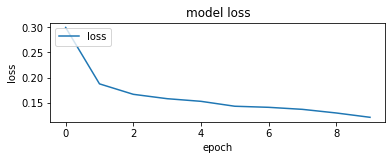

In [ ]:
plt.subplot(211)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss'], loc='upper left')